In [30]:
## To remove warnings
import os
os.environ['THEANO_FLAGS'] = 'blas.ldflags=-lopenblas'

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize


In [32]:
# Load the dataset
# Specify the path to the CSV file
filelocation = r"C:\Users\hp\Downloads\MMM_test_data.csv"

# Read the CSV file into a DataFrame
data = pd.read_csv(filelocation)

In [33]:
data.head()

,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,30-08-20,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
1,06-09-20,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2,13-09-20,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
3,20-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
4,27-09-20,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48


In [34]:
#Check data types and null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   start_of_week    104 non-null    object 
 1   revenue          104 non-null    float64
 2   spend_channel_1  104 non-null    float64
 3   spend_channel_2  104 non-null    float64
 4   spend_channel_3  104 non-null    float64
 5   spend_channel_4  104 non-null    float64
 6   spend_channel_5  104 non-null    float64
 7   spend_channel_6  104 non-null    float64
 8   spend_channel_7  104 non-null    float64
dtypes: float64(8), object(1)
memory usage: 7.4+ KB


In [35]:
#Data description 
data.describe()

,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,136490.190673,1245.604808,343.640962,19507.177981,6915.136731,8575.611442,5063.699038,27701.367404
std,50810.253012,1388.384632,332.988218,8714.759886,3123.172035,6956.787524,6689.472660,12176.293684
min,63207.090000,0.000000,4.370000,5938.130000,3602.200000,747.460000,0.000000,9391.210000
25%,101675.685000,334.275000,120.470000,13879.000000,5113.937500,2902.032500,0.000000,19797.710000
50%,128790.460000,856.870000,202.020000,17929.450000,6194.400000,6879.270000,2423.095000,24248.640000
75%,157707.280000,1658.032500,553.075000,22252.262500,7470.557500,14367.582500,8701.960000,33852.652500
max,418186.380000,8513.830000,1605.850000,49689.380000,22629.690000,33009.650000,33692.830000,77488.420000


In [36]:
# Convert the 'start_of_week' column to datetime
data['start_of_week'] = pd.to_datetime(data['start_of_week'], format='%d-%m-%y')

# Extract year, month, quarter, and week of year
data['year'] = data['start_of_week'].dt.year
data['month'] = data['start_of_week'].dt.month
data['quarter'] = data['start_of_week'].dt.quarter
data['week_of_year'] = data['start_of_week'].dt.isocalendar().week

# Create trend variable to calculate trends assuming a linear trend
data['trend'] = np.arange(len(data))
##np.random.seed(42)


## Calculating the initial Baysian model for Decay factor

In [37]:
# Standardize the data
channels = [f'spend_channel_{i}' for i in range(1, 8)]
scaler = StandardScaler()
X_initial = scaler.fit_transform(data[channels + ['trend']].values)
y = np.log(data['revenue'].values)

# Define and sample the initial Bayesian model
with pm.Model() as initial_model:
    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=8)  # 7 channels + 1 for trend
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # Expected revenue
    y_hat = intercept + pm.math.dot(X_initial, beta)
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma, observed=y)
    
    # Sampling
    initial_trace = pm.sample(2000, tune=1000, cores=2, target_accept=0.95)


C:\Users\hp\AppData\Local\Temp\ipykernel_2804\4105210672.py:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  initial_trace = pm.sample(2000, tune=1000, cores=2, target_accept=0.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 52 seconds.


## Calculate Optimal Decay factor for each Channel

In [38]:
# Define the adstock function
def adstock_transform(spend, decay):
    adstocked = np.zeros_like(spend)
    for t in range(len(spend)):
        if t == 0:
            adstocked[t] = spend[t]
        else:
            adstocked[t] = spend[t] + adstocked[t-1] * decay
    return adstocked

# Define the objective function to minimize
def objective_function(decay_factors):
    predicted_revenue = np.zeros(len(data))
    for i, channel in enumerate(channels):
        spend = data[channel].values
        adstocked_spend = adstock_transform(spend, decay_factors[i])
        predicted_revenue += adstocked_spend * initial_trace['beta'][:, i].mean()  # Use mean of beta from trace
    
    return np.sum((np.log(data['revenue']) - predicted_revenue) ** 2)

# Initial value for decay factors=0.5
initial_guess = np.ones(len(channels)) * 0.5

# Minimize the objective function to find optimal decay factors
result = minimize(objective_function, initial_guess, method='Nelder-Mead')

# Optimal decay factors
optimal_decay_factors = result.x
print("Optimal Decay Factors:")
for i, channel in enumerate(channels):
    print(f"{channel}: {optimal_decay_factors[i]}")


Optimal Decay Factors:
spend_channel_1: 0.9852227240247096
spend_channel_2: -0.7040077560788411
spend_channel_3: 0.5464040234575489
spend_channel_4: -0.9171328511104306
spend_channel_5: -0.8511968564590799
spend_channel_6: -0.8236495058492714
spend_channel_7: -0.571969909880639


In [39]:
# Apply adstock transformation to each channel with calculated optimal decay factors
for i, channel in enumerate(channels):
    adstock_channel_name = f'adstock_{channel}'
    data[adstock_channel_name] = adstock_transform(data[channel], optimal_decay_factors[i])

# Standardize the data including adstocked channels and trend
X = scaler.fit_transform(data[[f'adstock_spend_channel_{i}' for i in range(1, 8)] + ['trend']].values)


## Bayesian MMM with optimal decay factors

In [40]:
# Define the Bayesian Media Mix Model
with pm.Model() as model:
    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=8)  # 7 channels + 1 for trend
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # Expected revenue
    y_hat = intercept + pm.math.dot(X, beta)
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma, observed=y)
    
    # Sampling
    trace = pm.sample(2000, tune=1000, cores=2, target_accept=0.95)

# Summarize the trace
summary = pm.summary(trace)
print(summary)


C:\Users\hp\AppData\Local\Temp\ipykernel_2804\1738305843.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, tune=1000, cores=2, target_accept=0.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 47 seconds.
C:\Users\hp\anaconda3\envs\pymc3_env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  11.768  0.024  11.721   11.812      0.000    0.000    5240.0   
beta[0]    -0.074  0.043  -0.155    0.006      0.001    0.001    4380.0   
beta[1]    -0.018  0.033  -0.077    0.047      0.001    0.000    4176.0   
beta[2]     0.105  0.031   0.048    0.166      0.000    0.000    4518.0   
beta[3]     0.038  0.029  -0.017    0.089      0.000    0.000    3891.0   
beta[4]    -0.027  0.034  -0.092    0.036      0.001    0.000    4183.0   
beta[5]     0.051  0.033  -0.011    0.112      0.001    0.000    4290.0   
beta[6]     0.093  0.033   0.032    0.158      0.001    0.000    4362.0   
beta[7]    -0.120  0.044  -0.207   -0.040      0.001    0.000    4120.0   
sigma       0.253  0.019   0.218    0.286      0.000    0.000    4796.0   

           ess_tail  r_hat  
intercept    3120.0    1.0  
beta[0]      2910.0    1.0  
beta[1]      3050.0    1.0  
beta[2]      2884.0    1.0  
beta[3]      2647.0    1.0  


## Compare prior vs posterior

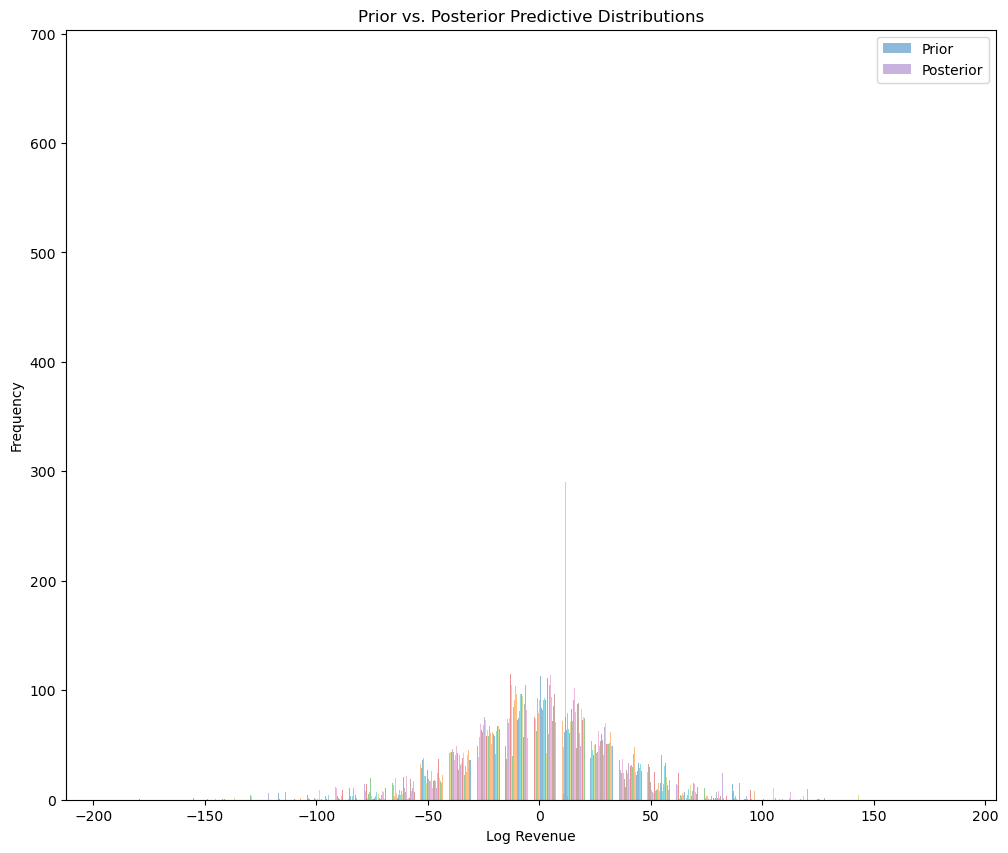


Prior Predictive Distribution Summary:
    mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x -0.289  32.312 -60.614   61.059      0.741    0.524    1845.0    5102.0   

   r_hat  
x    1.2  

Posterior Predictive Distribution Summary:


C:\Users\hp\anaconda3\envs\pymc3_env\lib\site-packages\arviz\data\base.py:169: UserWarning: More chains (500) than draws (104). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
C:\Users\hp\anaconda3\envs\pymc3_env\lib\site-packages\arviz\data\base.py:169: UserWarning: More chains (4000) than draws (104). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x  11.768  0.344  11.128   12.421      0.001    0.001   72463.0  248435.0   

   r_hat  
x   1.04  
R-squared: 0.4527551615488148


In [63]:

with model:
    prior_pred = pm.sample_prior_predictive()
    posterior_pred = pm.sample_posterior_predictive(trace)

# Plot prior vs. posterior
plt.figure(figsize=(12, 10))
plt.hist(prior_pred['y_like'], bins=30, alpha=0.5, label='Prior')
plt.hist(posterior_pred['y_like'], bins=30, alpha=0.5, label='Posterior')
plt.legend()
plt.xlabel('Log Revenue')
plt.ylabel('Frequency')
plt.title('Prior vs. Posterior Predictive Distributions')
plt.show()

# Textual summaries
print("\nPrior Predictive Distribution Summary:")
print(pm.summary(prior_pred['y_like']))

print("\nPosterior Predictive Distribution Summary:")
print(pm.summary(posterior_pred['y_like']))

# Model performance: R-squared
y_pred = np.exp(posterior_pred['y_like'].mean(axis=0))
y_true = data['revenue'].values
r_squared = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
print(f'R-squared: {r_squared}')


## Channel performance

Channel 1 mean beta: -0.07362319172099753
Channel 2 mean beta: -0.017976912813602048
Channel 3 mean beta: 0.10486730731689409
Channel 4 mean beta: 0.037607148450844764
Channel 5 mean beta: -0.02746115220812793
Channel 6 mean beta: 0.05098001771805232
Channel 7 mean beta: 0.0932100069297602
Best channel in terms of ROI: Channel 6


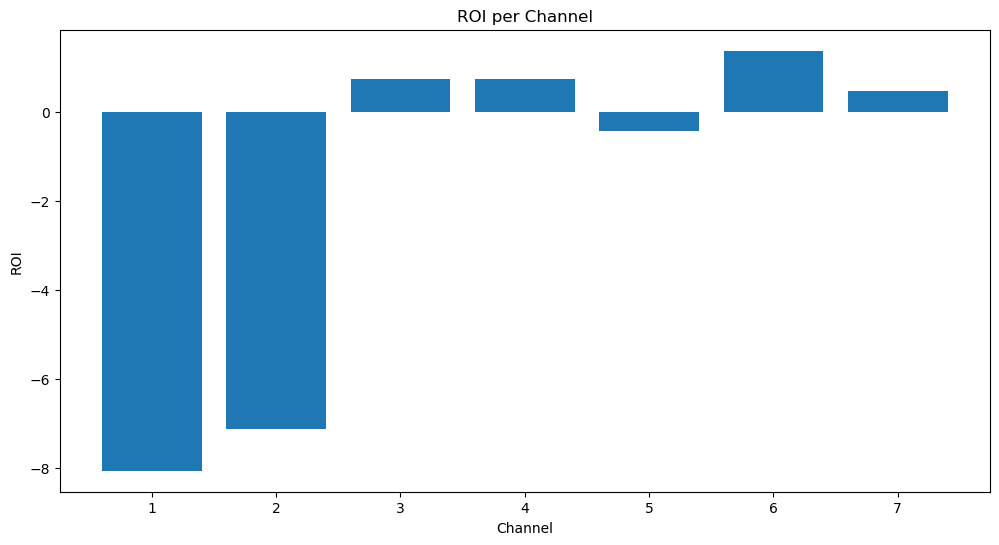

In [42]:
# Main insights: Channel performance/effects
betas = trace['beta'][:, :-1]  # Exclude the last beta which is for trend
for i in range(7):
    print(f'Channel {i+1} mean beta: {np.mean(betas[:, i])}')

# ROI estimates per channel
roi = []
for i in range(7):
    mean_beta = np.mean(betas[:, i])
    mean_spend = np.mean(data[f'spend_channel_{i+1}'])
    roi.append((mean_beta * np.mean(y_true)) / mean_spend)

# Best channel in terms of ROI
best_channel = np.argmax(roi) + 1
print(f'Best channel in terms of ROI: Channel {best_channel}')

# Plot ROIs
plt.figure(figsize=(12, 6))
plt.bar(range(1, 8), roi)
plt.xlabel('Channel')
plt.ylabel('ROI')
plt.title('ROI per Channel')
plt.show()


## Aggregate ROI analysis across samples


Channel 1 mean ROI: -8.067441144978083 (95% HDI: -17.55054863882923 - 1.2429937473231212)
Channel 2 mean ROI: -7.140220556527578 (95% HDI: -33.14827974475272 - 18.595676666350727)
Channel 3 mean ROI: 0.7337483046069271 (95% HDI: 0.30524907703030124 - 1.1669286660107558)
Channel 4 mean ROI: 0.7422856644159976 (95% HDI: -0.329892948408873 - 1.847039916528128)
Channel 5 mean ROI: -0.4370741289067939 (95% HDI: -1.5279575305690007 - 0.6418080051822548)
Channel 6 mean ROI: 1.374148085421735 (95% HDI: -0.33224827909889 - 3.1502039874382395)
Channel 7 mean ROI: 0.45926439056273455 (95% HDI: 0.1390267902548522 - 0.7910981546878015)
Best channel in terms of ROI: Channel 6


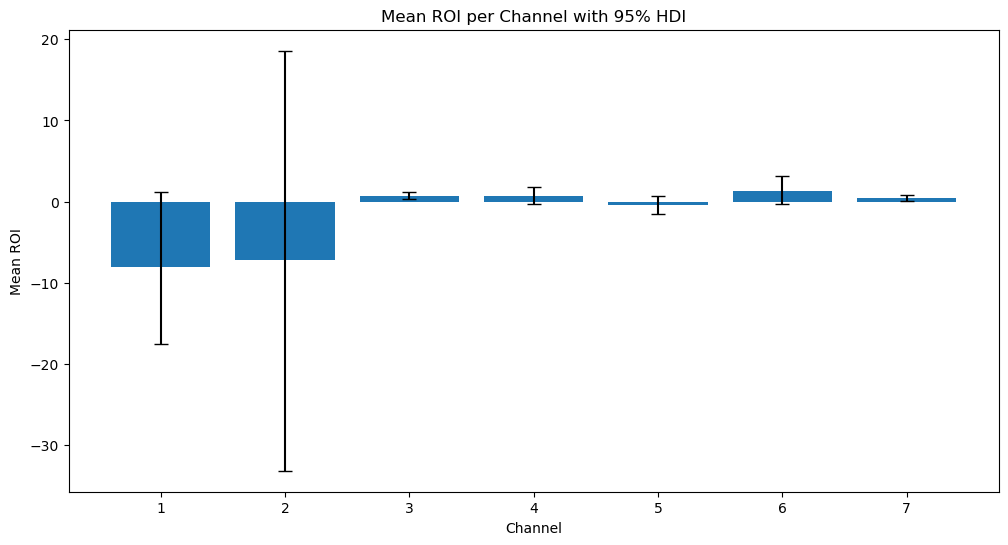

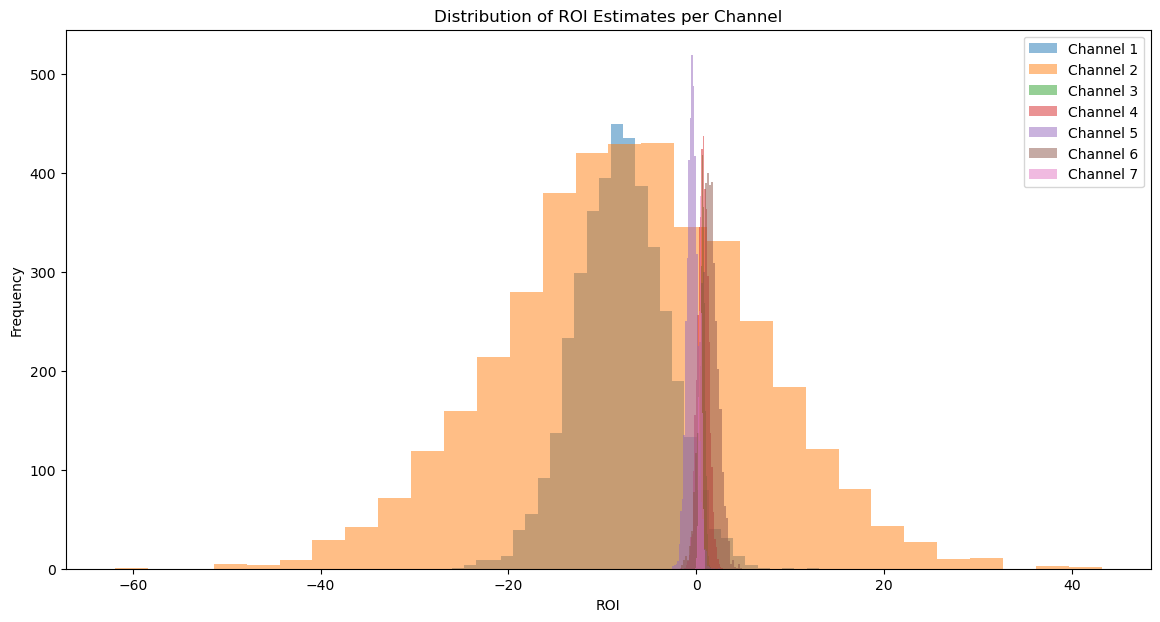

In [43]:
# Extract beta values from the trace (excluding trend)
betas = trace['beta'][:, :-1]

# Initialize a list to store ROI estimates across all samples
all_roi = []

# Calculate the ROI for each channel for each sample
for sample_idx in range(betas.shape[0]):
    roi_sample = []
    for i in range(7):
        beta_sample = betas[sample_idx, i]
        mean_spend = np.mean(data[f'spend_channel_{i+1}'])
        roi_sample.append((beta_sample * np.mean(y_true)) / mean_spend)
    all_roi.append(roi_sample)

# Convert all_roi to a numpy array for easier manipulation
all_roi = np.array(all_roi)

# Calculate aggregate statistics across all samples
mean_roi = np.mean(all_roi, axis=0)
hdi_2_5 = np.percentile(all_roi, 2.5, axis=0)
hdi_97_5 = np.percentile(all_roi, 97.5, axis=0)

# Identify the best channel based on mean ROI
best_channel = np.argmax(mean_roi) + 1

# Print mean ROI for each channel
for i in range(7):
    print(f'Channel {i+1} mean ROI: {mean_roi[i]} (95% HDI: {hdi_2_5[i]} - {hdi_97_5[i]})')

# Print best channel based on mean ROI
print(f'Best channel in terms of ROI: Channel {best_channel}')

# Plot mean ROIs with 95% HDI across all channels
plt.figure(figsize=(12, 6))
plt.bar(range(1, 8), mean_roi, yerr=[mean_roi - hdi_2_5, hdi_97_5 - mean_roi], capsize=5)
plt.xlabel('Channel')
plt.ylabel('Mean ROI')
plt.title('Mean ROI per Channel with 95% HDI')
plt.show()

# Plot the distribution of ROI estimates for each channel
plt.figure(figsize=(14, 7))
for i in range(7):
    plt.hist(all_roi[:, i], bins=30, alpha=0.5, label=f'Channel {i+1}')
plt.legend()
plt.xlabel('ROI')
plt.ylabel('Frequency')
plt.title('Distribution of ROI Estimates per Channel')
plt.show()